# Numerical experiments "Towards Model-Agnostic Federated Learning over Networks" IV-A Synthetic Dataset - clustered dataset

In [290]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
import torch

# plt settings
plt.rcParams.update({'axes.spines.right': False,
                     'axes.spines.top': False})
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

In [257]:
save_npy = False

# Regression experiments

## Clustered synthetic dataset

Experiments are performed on a synthetic dataset whose empirical graph $\mathcal {G}$ is partitioned into 3 equal-sized clusters $\mathcal{P} = \{\mathcal{C}^{(1)}, \mathcal{C}^{(2)},  \mathcal{C}^{(2)}\}$, with $|\mathcal{C}^{(1)}|=|\mathcal{C}^{(2)}|=|\mathcal{C}^{(3)}|=50$. We denote the cluster assignment of node $i \in \mathcal{V}$ by ${c}^{(i)} \in \{0,1,2\}$. 

Each node $i \in \mathcal {V}$ of the empirical graph $\mathcal {G}$ holds a local dataset $\mathcal {D}^{(i)}$ of the form $\mathcal {D}^{(i)} := \{ (\mathbf{x}^{(i,1)}, {y}^{(i,1)}), ..., (\mathbf{x}^{(i,{m}_{i})}, {y}^{(i,{m}_{i})}) \}$. Thus, dataset $\mathcal {D}^{(i)}$ consist of ${m}_{i}$ data points, each characterized by a feature vector $\mathbf{x}^{(i,r)} \in \mathbb{R}^{d}$ and scalar label ${y}^{(i,r)}$, for $r=1,...,{m}_{i}$. The feature vectors $\mathbf{x}^{(i,r)} \sim \mathcal{N}(\mathbf{0},\mathbf{I}_{d})$, are drawn i.i.d. from a standard multivariate normal distribution. 

The labels of the data points are generated by a noisy linear model
\begin{equation}
{y}^{(i,r)} = (\mathbf{w}^{(i)})^T\mathbf{x}^{(i,r)} + {\varepsilon}^{(i,r)}
\end{equation}

The noise ${\varepsilon}^{(i,r)} \sim \mathcal{N}(0, {\sigma}^{2})$, for $i \in \mathcal{V}$ and $r=1,..,{m}_{i}$, are i.i.d. realizations of a normal distribution. The true underlying vector $\mathbf{w}^{(i)} \sim \mathcal{N}(0,1)$ is drawn from a standard normal distribution and is the same for nodes from the same cluster, i.e. $\mathbf{w}^{(i)}=\mathbf{w}^{({i}^{'})}$ if ${c}^{(i)}={c}^{({i}^{'})}$.

In addition to the local training dataset of size $m_i$, we generate validation subset with ${m}^{(val)}_{i}=100$ datapoints from the same distribution.

Dataset $\mathcal{P}^{(i)}$ is unlabeled dataset with feature vectors drawn i.i.d. from a standard normal distribution $\mathbf{x}^{(i,r)} \sim \mathcal{N}(\mathbf{0},\mathbf{I}_{d})$. The size of the dataset is $m_i^{(\mathcal{P})}=100$. This shared public dataset can be the same on all nodes or different for each node.

In [258]:
def get_data(n_clusters, n_ds, n_samples, n_features, noise_scale=1.0):
    
    """
    
    Function to create noisy Gaussian regression datasets. 
    Datasets within the cluster share the same true weight vector. 
    For each node we create training (size = n_samples) and validation (size = 100) ds.
    
    :param n_clusters:   number of clusters
    :param n_ds:         number of local datasets per cluster 
    :param n_samples:    number of samples in a local dataset
    :param n_features:   number of features of a datapoint
    :param noise_scale:  scale of normal distribution used to generate data noise
    
    :out ds_train:       list of (n_clusters*n_ds) local train datasets of sample size n_samples
    :out ds_val:         list of (n_clusters*n_ds) local validation datasets of sample size 100
    :out cluster_labels: list of (n_clusters*n_ds) cluster assignments for each local dataset 
    :out true_weights:   array of shape (n_clusters, n_features), true weight vector for each cluster

    """
    
    # Lists to store and return outputs
    ds_train       = []
    ds_val         = []
    cluster_labels = []
    true_weights   = np.zeros((n_clusters, n_features))
    
    for i in range(n_clusters):
        
        # Sample true weight vector for cluster i
        w = np.random.normal(0, 1, size=(n_features,1))
        true_weights[i] = w.reshape(-1,)

        for j in range(n_ds):
            # Sample datapoints from multivar Gaussian ~N(0,I)
            X = np.random.normal(0, 1.0, size=(1000, n_features))
            
            # Sample noise 
            noise = np.random.normal(loc=0.0, scale=noise_scale, size=(1000, 1))
            
            # Noisy Gaussian regression
            y = X@w + noise
            
            X_train, y_train = resample(X, y, n_samples=n_samples)
            X_val, y_val = resample(X, y, n_samples=100)

            ds_train.append( (X_train, y_train) )
            ds_val.append( (X_val, y_val) )
            
            cluster_labels.append(i)

    return ds_train, ds_val, cluster_labels, true_weights

In [259]:
def get_data_gauss(n_nodes, m_pub, n_features):

    """

    Create Gaussian dataset for all nodes.

    Args:
    : n_nodes    : scalar, number of nodes
    : m_pub      : scalar, number of samples in shared public dataset
    : n_features : scalar, number of features of a datapoint
    Out:
    : data_test  : array of shape (n_nodes, m_pub, n_features), feature matrix

    """

    ds_pub = np.random.normal(0, 1.0, size=(n_nodes, m_pub, n_features))

    return ds_pub

## Graph

In [260]:
def build_graph(ds_train, ds_val, models, cluster_labels):

    """

    Function to generate graph.

    :param ds_train:       list of (n_clusters*n_ds) local train datasets of sample size n_samples (see function `get_data()`)
    :param ds_val:         list of (n_clusters*n_ds) local validation datasets of sample size 100
    :param models:         list of (n_clusters*n_ds) local models
    :param cluster_labels: list of (n_clusters*n_ds) cluster assignments for each local dataset 

    :out G:                list of (n_clusters*n_ds) python dictionaries (graph nodes) where each dict (node)  contain local train/ val datasets, model and shared test dataset

    """
    G = []
    for ds_t, ds_v, model, c in zip(ds_train, ds_val, models, cluster_labels):
        G.append({"ds_train": ds_t, "ds_val": ds_v, "model": model, "cluster_label": c}) 
        
    return G

In [261]:
def build_edges(G, cluster_labels, p_in = 0.8, p_out = 0.2):

    """

    Create network edges (links) with Bernoulli distribution P(n) = p^n(1-p)^(1-n), where n={0,1}.
    Probability p_in for nodes within a cluster and probability p_out for nodes from different clusters.
    Edge weights are the same for all edges A_ij = 1; for A_ii = 0

    :param G:              list of (n_clusters*n_ds) python dictionaries (graph nodes) where each dict (node)  contain local train/ val datasets, model and shared dataset
    :param cluster_labels: list of (n_clusters*n_ds) cluster assignments for each local dataset 
    :param p_in:           probability of a link between nodes belonging to the same cluster 
    :param p_out:          probability of a link between nodes belonging to different clusters 

    :out A:                numpy array of shape (n_nodes, n_nodes), adjacency matrix of the graph, created with Bernoulli distribution and probabilities p_in and p_out.

    """
    
    nn = len(G)
    A = np.zeros((nn, nn))
    rows, cols = A.shape

    for i in range(rows):
        for j in range(cols):
            if i==j:
                A[i,j] = 0
            elif cluster_labels[i] == cluster_labels[j]:
                A[i,j] = np.random.binomial(n=1, p=p_in, size=5)[0] 
            else:
                A[i,j] = np.random.binomial(n=1, p=p_out, size=5)[0]

    # Create a symmetric matrix           
    A = np.tril(A) 
    A = A + A.T
    return A

In [262]:
def concat(ds):

    """

    Function to pool data for G_pooled.

    """
    Xs = []
    ys = []
    for X, y in ds:
        Xs.append(X)
        ys.append(y)
    return np.concatenate(Xs), np.concatenate(ys)  
    
def build_graph_oracle(ds_train, ds_val, models, n_clusters=3):
    
    """
    Graph with n_clusters nodes. 
    For each node (corresponding to one cluster), local training dataset is pooled train ds of all nodes belonging to that cluster. 
    """
    
    n_ds = int(len(ds_train) / n_clusters)

    G = []
    for i in range(n_clusters):
        G.append({ 
                "model": models[i], 
                "ds_train": concat(ds_train[i*n_ds: i*n_ds+n_ds]), 
                "ds_val": concat(ds_val[i*n_ds: i*n_ds+n_ds])
                 }) 
        
    return G    

## Training loop

In [263]:
def train(G, A, G_oracle, ds_pub, true_weights, iters=1000, reg=0.01, parametric=False): 
    
    """
    Args:
    
    : G              : list of dicts [dict keys are: model, ds_train, ds_val, ds_shared, cluster_label], 
                       represents graph with n_nodes
    : A              : array, adjacency matrix
    : G_oracle       : list of dicts [dict keys are: model, ds_train, ds_val], 
                       represents graph with n_cluster nodes (local ds size = n_ds*n_samples). 
                       Data belonging to the ith-node is aggregated ds of G, belonging to the ith-cluster. 
    : ds_pub         : array of size (n_nodes, m_pub, n_features), shared public dataset
    : true_weights   : array of size (n_clusters, n_features), true weight vector used in data generation
    : iters          : scalar, number of iterations or updates of the local model
    : reg            : scalar, scaling factor \alpha in GTV term
    : parametric     : boolean, indicates if MSE for weight vectors should be computed

    Out:

    : est_error      : array of size (n_nodes, iters), MSE for weight vectors should be computed
    : mse_train      : array of size (n_nodes, iters), MSE on local training set incurred by local model
    : mse_val        : array of size (n_nodes, iters), MSE on local validation set incurred by local model
    : mse_val_oracle : array of size (n_nodes, iters), MSE on local validation set incurred by Oracle model
    
    """
    
    n_nodes      = len(G)                             # number of nodes in a graph
    n_clusters   = len(G_oracle)                      # number of disjoint clusters 
    m_pub        = ds_pub.shape[1]                    # sample size of the shared public ds
    nodes_preds  = np.zeros((n_nodes, m_pub))         # init predictions on a shared public ds

    # Estimated error for parameter vector 
    err        = np.zeros((n_nodes, iters))
    err_oracle = np.zeros((n_clusters, iters))
    # MSE on training/validation subsets
    mse_train      = np.zeros((n_nodes, iters))
    mse_val        = np.zeros((n_nodes, iters))
    mse_val_oracle = np.zeros((n_nodes, iters))

    # Training loop
    for i in range(iters):
        for n in range(n_nodes):
            # get node's data
            ds_train  = G[n]["ds_train"]
            ds_val    = G[n]["ds_val"]
            model     = G[n]["model"]
            c         = G[n]["cluster_label"]
            if parametric: 
                # compute MSE^{(w)}
                w = true_weights[c]
                w_hat  = model.get_params().reshape(-1,)
                err[n,i] = np.mean((w - w_hat)**2)
            # get corresponding Oracle model 
            model_oracle  =  G_oracle[c]["model"]

            # model predictions
            pred_train  = model.predict(ds_train[0])
            pred_val    = model.predict(ds_val[0])
            pred_oracle = model_oracle.predict(ds_val[0])
            # MSE on train/val subsets
            mse_train[n,i]      = np.mean((ds_train[1] - pred_train.reshape(-1,1))**2)
            mse_val[n,i]        = np.mean((ds_val[1] - pred_val.reshape(-1,1))**2)
            mse_val_oracle[n,i] = np.mean((ds_val[1] - pred_oracle.reshape(-1,1))**2)

            # Update local models
            _ = model.update(ds_train, ds_pub, nodes_preds, A[n], reg) 
            
        # Update predictions on a shared public datasets
        nodes_preds = np.zeros((n_nodes, m_pub))
        for n in range(n_nodes):
            model          = G[n]["model"]
            nodes_preds[n] = model.predict(ds_pub[n]).reshape(-1,)
        
        # Compute MSE^{(w)} and update Oracle models
        for n in range(n_clusters):
            # get node data
            ds_train = G_oracle[n]["ds_train"]
            model    = G_oracle[n]['model']
            # compute MSE^{(w)}
            if parametric: 
                w = true_weights[n]
                w_hat = model.get_params().reshape(-1,)
                err_oracle[n,i] = np.mean((w - w_hat)**2)
            # update local models    
            _ = model.update_oracle(ds_train) 

    return err, err_oracle, mse_train, mse_val, mse_val_oracle
        

## FedRelax for Parametric Models - Pytorch linear regressor

In [264]:
class Optimize(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        
    # Model prediction with tracking gradients
    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x)
        pred = self.model(x)
        return pred
    
    # Model prediction without tracking gradients
    def predict(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x)
        with torch.no_grad():
            pred = self.model(x)
        return pred.detach().numpy() 

    def update(self, ds_train, ds_pub, nodes_preds, A, regularizer_term):
        
        """
        Function to implement step (18) - min local loss + regularization term
        
        nn    - number of nodes
        m_pub - sample size of shared public dataset; for convenience it is same for all nodes

        Args:
        : ds_train         : tuple of arrays (X,y) of sizes (n_samples, n_features) and (n_samples, 1)
        : ds_pub           : array of size (n_nodes, m_pub, n_features), public datasets shared with other nodes
        : nodes_preds      : predictions on ds_pub by the local model on the node, array of size (n_nodes, m_pub)
        : A                : array of size (nn,), edges' weights, row of a symmetric matrix A; A_ii=0 (zero diagonal)
        : regularizer_term : scalar, scaling factor \alpha in GTV term
        
        """
        # Local training set
        X, y = ds_train[0], ds_train[1]

        # Convert numpy arrays to torch tensors
        X, y = torch.FloatTensor(X), torch.FloatTensor(y)
        ds_pub = torch.FloatTensor(ds_pub) 
        
        A = torch.from_numpy(A).float().reshape(-1,1)   # shape (n_nodes,1)
        nodes_preds = torch.from_numpy(nodes_preds).float() # shape (n_nodes,m_pub)

        # Get predictions for local and shared public ds
        pred = self.model(X)
        pred_pub = self.model(ds_pub)  # out shape (n_nodes,m_pub,1)
        
        # Set all gradient values to zeros
        self.model.zero_grad()  
        
        # Compute loss
        loss_local = self.criterion(y, pred)
        loss_GTV = torch.mean( ((torch.squeeze(pred_pub) - nodes_preds)**2).T@A )
        loss = loss_local + regularizer_term*loss_GTV
        
        # Backpropagate the gradients
        loss.backward()

        # Update parameters of the model using the chosen optimizer
        self.optimizer.step()

        return loss.item()
    
    def update_oracle(self, ds_train):
        
        """
        Simple Gradient Step without penalty term.
        """
        
        X, y = ds_train[0], ds_train[1]
        X, y = torch.FloatTensor(X), torch.FloatTensor(y)

        # Get predictions for local and shared pub ds
        pred = self.model(X)
        
        # Set all gradient values to zeros
        self.model.zero_grad()  
        
        # Compute loss
        loss = self.criterion(y, pred)
        
        # Backpropagate the gradients
        loss.backward()

        # Update parameters of the model using the chosen optimizer
        self.optimizer.step()

        return loss.item()

class Linreg_Torch(Optimize):
    def __init__(self, n_features, lr=0.001, bias=True):
        Optimize.__init__(self)
        
        # Define model
        if bias==False:
            self.model = torch.nn.Linear(n_features, 1, bias=False)
        else:
            self.model = torch.nn.Linear(n_features, 1)
            
        # Define Loss and Optimizer
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr)
        
    def get_params(self):
        params = [layer.data for layer in self.model.parameters()][0].numpy()
        return params

### Configuration

We generate $n = 150$ local datasets belonging to 3 disjoint clusters as described above. 

In [265]:
def experiment (reg_term, n_features, noise, iters):
    # prob of edges
    p_in, p_out = 0.8, 0.2
    
    n_clusters, n_ds, n_samples = 3, 50, 10
    m_pub          = 100
    n_nodes        = n_clusters * n_ds
    rep            = 5 # repeat experiment 

    # MSE for parameter vector 
    err_ = np.zeros((rep, n_nodes, iters))
    # MSE on train/validation subsets
    mse_train_, mse_val_ = np.zeros((rep, n_nodes, iters)), np.zeros((rep, n_nodes, iters))

    for i in range(rep):
        
        # Create linear pytorch models
        models = [Linreg_Torch(n_features, lr=0.01, bias=False) for i in range(n_clusters*n_ds)]
        models_oracle = [Linreg_Torch(n_features,  lr=0.01, bias=False) for i in range(n_clusters)]
    
        # Create a dataset
        ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features, noise)
        # shared public dataset is sampled from Gaussian distr ~N(0,1) for each node
        # array of shape (n_nodes, m_pub, n_features)
        ds_pub = get_data_gauss(n_nodes, m_pub, n_features)
        
        # Build a graph with nodes {model, local dataset (with train/val subsets), public dataset, cluster label}
        G = build_graph(ds_train, ds_val, models, cluster_labels)
        A = build_edges(G, cluster_labels, p_in = p_in, p_out = p_out)
        # Oracle graph, each node corresponds to all nodes of G of the same cluster
        G_oracle = build_graph_oracle(ds_train, ds_val, models_oracle, n_clusters)
        err, err_oracle, mse_train, mse_val, mse_val_oracle = train(G, A, G_oracle, ds_pub, true_weights, iters, reg_term, parametric=True)

        err_[i] = err
        mse_train_[i], mse_val_[i] = mse_train, mse_val
        
    return np.mean(err_, axis=(0,1)), np.mean(mse_train_, axis=(0,1)), np.mean(mse_val_, axis=(0,1))
          

### Different d/m ratio

In [293]:
%%time
# vary number of features, fixed local training ds size m_i=10
# d = 2, 10, 20, 50, 100 ~> d/m = 0.2, 1, 2, 5, 10 
d = [2, 10, 20, 50, 100]
reg   = [0, 0.01, 0.05]
noise = 0
iters = 500

if save_npy:
    err            = np.zeros((len(reg),len(d), iters))
    mse_train      = np.zeros((len(reg),len(d), iters))
    mse_val        = np.zeros((len(reg),len(d), iters))

    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for n_features in d)
        
        for j in range(len(d)):
            err[i,j]            = out[j][0]
            mse_train[i,j]      = out[j][1]
            mse_val[i,j]        = out[j][2]

CPU times: user 8 μs, sys: 17 μs, total: 25 μs
Wall time: 29.1 μs


In [294]:
if save_npy:
    np.save("Pytorch_clustered_w_err", err)
    np.save("Pytorch_clustered_mse_train", mse_train)
    np.save("Pytorch_clustered_mse_val", mse_val)
else:
    err = np.load("Pytorch_clustered_w_err.npy")
    mse_train = np.load("Pytorch_clustered_mse_train.npy")
    mse_val = np.load("Pytorch_clustered_mse_val.npy")

**Model performance: estimated weight vector MSE**

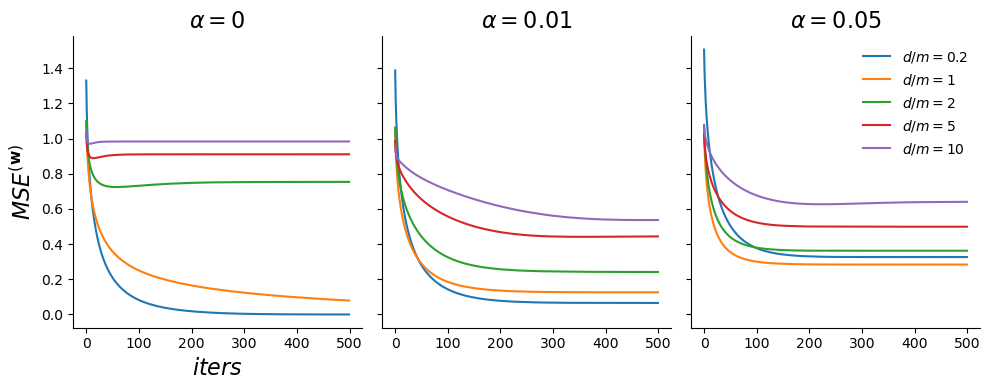

In [295]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
titles = [r'$\alpha=0$', r'$\alpha=0.01$', r'$\alpha=0.05$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(10,4))

for ax, mse, title in zip(axs, err, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(\mathbf{w})}$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
#fig.suptitle('Algorithm FedRelax weight vector MSE w.r.t. $d/m$ ratio')
fig.tight_layout()
plt.savefig("Pytorch_clustered_w_err_dm.png")
plt.show()

**Model performance: MSE on validation set**

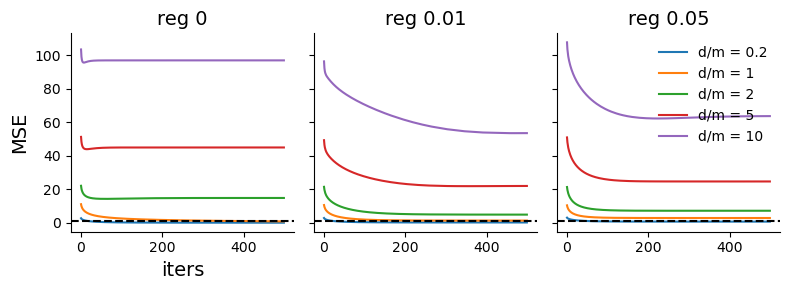

In [213]:
# d = 2, 10, 20, 50, 100  ~> d/m = 0.2, 1, 2, 5, 10

labels = ['d/m = 0.2', 'd/m = 1', 'd/m = 2', 'd/m = 5', 'd/m = 10']
titles = ['reg 0', 'reg 0.01', 'reg 0.05']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_val, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)
    ax.axhline(y=1,ls='--', c='k')

axs[0].set_ylabel ('MSE')
axs[0].set_xlabel ('iters')
plt.legend(frameon=False)
#fig.suptitle('FedRelax $MSE^{(val)}$ set w.r.t. $d/m$ ratio')
fig.tight_layout()
#plt.savefig("Pytorch_reg_val_dm.png")
plt.show()

### Different noise levels

In [296]:
%%time

n_features = 10
reg   = [0, 0.01, 0.05]
noise_vals = [0, 0.1, 1, 5]
iters = 500

if save_npy:
    err_noise       = np.zeros((len(reg),len(noise_vals), iters))
    mse_train_noise = np.zeros((len(reg),len(noise_vals), iters))
    mse_val_noise   = np.zeros((len(reg),len(noise_vals), iters))
    
    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for noise in noise_vals)
        
        for j in range(len(noise_vals)):
            err_noise[i,j]            = out[j][0]
            mse_train_noise[i,j]      = out[j][1]
            mse_val_noise[i,j]        = out[j][2]

CPU times: user 12 μs, sys: 19 μs, total: 31 μs
Wall time: 36 μs


In [297]:
if save_npy:
    np.save("Pytorch_clustered_w_err_noise", err_noise)
    np.save("Pytorch_clustered_mse_train_noise", mse_train_noise)
    np.save("Pytorch_clustered_mse_val_noise", mse_val_noise)
else:
    err_noise = np.load("Pytorch_clustered_w_err_noise.npy")
    mse_train_noise = np.load("Pytorch_clustered_mse_train_noise.npy")
    mse_val_noise = np.load("Pytorch_clustered_mse_val_noise.npy")

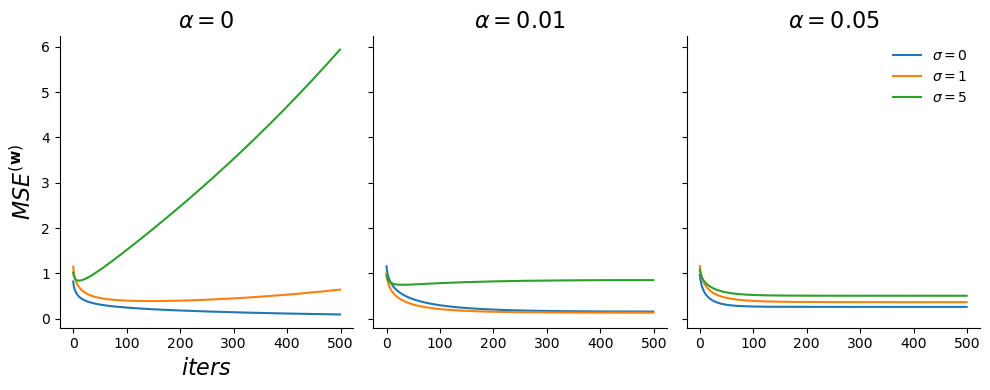

In [298]:
labels = [r'$\sigma = 0$', r'$\sigma = 0.1$', r'$\sigma = 1$', r'$\sigma = 5$']
titles = [r'$\alpha=0$', r'$\alpha=0.01$', r'$\alpha=0.05$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(10,4))

for ax, mse, title in zip(axs, err_noise, titles):
    for i in [0,2,3]:
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(\mathbf{w})}$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
#fig.suptitle('FedRelax weight vector MSE w.r.t. noise level, d/m=1')
fig.tight_layout()
plt.savefig("Pytorch_clustered_w_err_noise.png")
plt.show()

### Benchmarking - FedAvg, IFCA

In [299]:
def ifca(n_clusters, ds_train, ds_val, cluster_labels_true, true_weights, iters, lrate):

    n_nodes, n_features = len(ds_train), ds_train[0][0].shape[1]
    # init clusters weights
    weights = np.random.uniform(-np.sqrt(1/n_features), np.sqrt(1/n_features), size=(n_clusters, n_features))
    
    # store weight vector est.error := ||w_hat - w_true||^2 and MSE on train/val
    err       = np.zeros((n_nodes, iters)) 
    mse_train = np.zeros((n_nodes, iters)) 
    mse_val   = np.zeros((n_nodes, iters)) 
    # loss and gradient on the nodes wrt different weight vectors
    loss       = np.zeros((n_nodes, n_clusters))
    gradients  = np.zeros((n_nodes, n_clusters, n_features))

    for iter in range(iters): 
        # For each client compute loss and gradient wrt different weight vectors
        for n in range(n_nodes):
            X, y =  ds_train[n][0], ds_train[n][1]
            for j in range(n_clusters):
                loss[n, j] = np.mean((y - X@weights[j].reshape(-1,1))**2)
                gradients[n, j] = ( (-2/len(y))*X.T@(y - X@weights[j].reshape(-1,1)) ).reshape(-1,)
        
        # Compute which weights/ cluster are giving smaller loss
        cluster_labels = np.argmin(loss, axis=1) 
        # select corresponding gradient 
        grads = np.zeros((n_nodes, n_features))
        for i in range(n_nodes) : grads[i] = gradients[i, cluster_labels[i]]
        
        # Compute average of the gradients over the clusters and update weights
        for i in range(n_clusters):
            # choose all clients with cluster label i
            idx = np.where(cluster_labels == i)[0]
            if len(idx) != 0:
                # average gradient over cluster i
                grad_aver = np.mean(grads[idx], axis=0)
                # update weight vector for the corresponding cluster
                weights[i] = weights[i] - lrate*grad_aver
        
        # compute losses and MSE^{(w)} for each node
        for n in range(n_nodes):
            c, c_true = cluster_labels[n], cluster_labels_true[n]
            w, w_true = weights[c], true_weights[c_true]
            X, y = ds_train[n][0], ds_train[n][1]
            X_val, y_val =  ds_val[n][0], ds_val[n][1]

            err[n,iter] = np.mean((w-w_true)**2)
            mse_train[n,iter] = np.mean((y - X@w.reshape(-1,1))**2)
            mse_val[n,iter]   = np.mean((y_val - X_val@w.reshape(-1,1))**2)

    return err, mse_train, mse_val
        

In [300]:
def FedAvg(ds_train, ds_val, cluster_labels, true_weights, iters, lrate):

    n_nodes, n_features = len(ds_train), ds_train[0][0].shape[1]
    # init clusters weights
    weights = np.random.uniform(-np.sqrt(1/n_features), np.sqrt(1/n_features), size=(n_features,1))
    
    # store weight vector est.error := ||w_hat - w_true||^2 and MSE on train/val
    err       = np.zeros((n_nodes, iters)) 
    mse_train = np.zeros((n_nodes, iters)) 
    mse_val   = np.zeros((n_nodes, iters)) 

    gradients  = np.zeros((n_nodes, n_features))

    for iter in range(iters): 
        # compute gradients
        for n in range(n_nodes):
            X, y =  ds_train[n][0], ds_train[n][1]
            gradients[n] = ( (-2/len(y))*X.T@(y - X@weights.reshape(-1,1)) ).reshape(-1,)

        # update weight vector
        weights = weights - lrate*(np.mean(gradients, axis=0).reshape(-1,1))

        # compute losses and MSE^{(w)} for each node
        for n in range(n_nodes):
            w_true = true_weights[cluster_labels[n]].reshape(-1,1)
            X, y = ds_train[n][0], ds_train[n][1]
            X_val, y_val =  ds_val[n][0], ds_val[n][1]

            err[n,iter] = np.mean((weights-w_true)**2)
            mse_train[n,iter] = np.mean((y - X@weights)**2)
            mse_val[n,iter]   = np.mean((y_val - X_val@weights)**2)

    return err, mse_train, mse_val
        

In [301]:
def experiment (reg_term, n_features, noise, iters):
    np.random.seed(0)
    # prob of edges
    p_in, p_out = 0.8, 0.2
    
    n_clusters, n_ds, n_samples = 5, 30, 10
    m_pub   = 100
    n_nodes = n_clusters * n_ds
    rep     = 5
    lrate   = 0.01

    # Estimated error for parameter vector 
    err_, err_oracle_ = np.zeros((rep, n_nodes, iters)), np.zeros((rep, n_clusters, iters))
    err_ifca_, err_ifca2_, err_fedavg_ = np.zeros((rep, n_nodes, iters)), np.zeros((rep, n_nodes, iters)),  np.zeros((rep, n_nodes, iters))
    
    for i in range(rep):
        
        # Create linear pytorch models
        models = [Linreg_Torch(n_features, lr=lrate, bias=False) for i in range(n_clusters*n_ds)]
        models_oracle = [Linreg_Torch(n_features,  lr=lrate, bias=False) for i in range(n_clusters)]
    
        # Create a dataset
        ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features, noise)
        # shared pub set is sampled from Gaussian distr ~N(0,1) for each node
        # array of shape (n_nodes, m_pub, n_features)
        ds_pub = get_data_gauss(n_clusters*n_ds, m_pub, n_features)
        
        # Build a graph with nodes {model, dataset local, dataset pub}
        G = build_graph(ds_train, ds_val, models, cluster_labels)
        A = build_edges(G, cluster_labels, p_in = p_in, p_out = p_out)
        # oracle graph, each node corresponds to all nodes of G of the same cluster
        G_oracle = build_graph_oracle(ds_train, ds_val, models_oracle, n_clusters=n_clusters)
        err, err_oracle, _, _, _ = train(G, A, G_oracle, ds_pub, true_weights, iters, reg_term, parametric=True)

        # ifca algo
        err_ifca, _, _ = ifca(n_clusters, ds_train, ds_val, cluster_labels, true_weights, iters, lrate=lrate)
        err_ifca2, _, _ = ifca(2, ds_train, ds_val, cluster_labels, true_weights, iters, lrate=lrate)
        err_fedavg, _, _ = FedAvg(ds_train, ds_val, cluster_labels, true_weights, iters, lrate=lrate)
        
        err_[i], err_oracle_[i] = err, err_oracle
        err_ifca_[i]   = err_ifca
        err_ifca2_[i]  = err_ifca2
        err_fedavg_[i] = err_fedavg

    return np.mean(err_, axis=(0,1)), np.mean(err_oracle_, axis=(0,1)),\
            np.mean(err_ifca_, axis=(0,1)), np.mean(err_ifca2_, axis=(0,1)), np.mean(err_fedavg_, axis=(0,1)) 


In [302]:
%%time

n_features = 50
reg   = [0, 0.01, 0.05]
noise = 0
iters = 500

err, err_oracle = np.zeros((len(reg), iters)), np.zeros((len(reg), iters))
err_ifca   = np.zeros((len(reg), iters))
err_ifca2  = np.zeros((len(reg), iters))
err_fedavg = np.zeros((len(reg), iters))

out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for reg_term in reg)

for i in range(len(reg)):
    err[i], err_oracle[i] = out[i][0], out[i][1]
    err_ifca[i]      = out[i][2]
    err_ifca2[i]     = out[i][3]
    err_fedavg[i]    = out[i][4]


CPU times: user 268 ms, sys: 291 ms, total: 559 ms
Wall time: 5min 34s


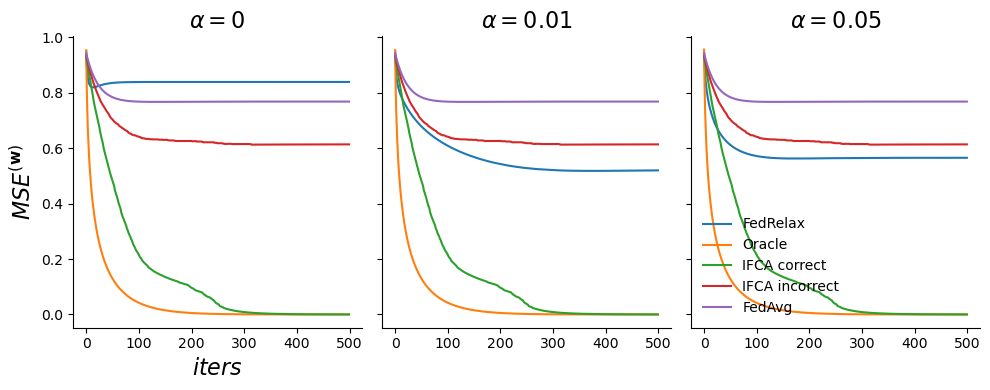

In [303]:
titles = [r'$\alpha=0$', r'$\alpha=0.01$', r'$\alpha=0.05$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(10,4))

for ax, ee, ee_oracle, ee_ifca, ee_ifca2, ee_fedavg, title in zip(axs, err, err_oracle, err_ifca, err_ifca2, err_fedavg, titles):
    ax.plot(np.arange(iters), ee, label='FedRelax')
    ax.plot(np.arange(iters), ee_oracle, label='Oracle')
    ax.plot(np.arange(iters), ee_ifca, label='IFCA correct')
    ax.plot(np.arange(iters), ee_ifca2, label='IFCA incorrect')
    ax.plot(np.arange(iters), ee_fedavg, label='FedAvg')
    ax.set_title(title)
    
axs[0].set_ylabel (r'$MSE^{(\mathbf{w})}$')
axs[0].set_xlabel ('$iters$')
plt.legend(frameon=False)
#fig.suptitle('FedRelax vs Oracle $MSE^{(val)}, d/m=5$')
fig.tight_layout()
plt.savefig("Pytorch_clustered_w_err_benchmark.png")
plt.show()

## FedRelax for Non-Parametric Models - SKlearn DT regressor

As model we use decision tree regressor implemented with python library scikit-learn. We implement line 4 of Algorithm 1, computing regularized local loss as defined in Eq.(11), by constructing augmented local dataset. Augmented dataset is the local dataset $\mathcal{D}^{(i)}$ augmented by the data points $(\mathbf{x},\widehat{h}^{(i')}((\mathbf{x}))$, $\mathbf{x} \in \mathcal{P}^{(i')}$ for all nodes $i' \sim \mathcal{N}^{(i)}$.
We initialize hypothesis $\widehat{h}^{(i)}$ by fitting decision tree regressor to the training set of the client $\mathcal{D}^{(i)}$.
To pass regularization parameter $\alpha$ in Eq.(11) to the training function, we use provided function argument called sample weight (see documentation https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.fit).

We run experiment for different values of data dimensionality $d = \{2,10,20,50,100 \}$.

In [123]:
class Data_augmentation():  
    @staticmethod
    def data_aug(ds_train, ds_pub, preds_pub, A, regularizer_term):
        
        """
        nn - number of nodes
        m_pub - sample size of shared pub data
        
        :param ds_train:         list of (n_clusters*n_ds) local train datasets of sample size n_samples
        :param ds_pub:           array of size(n_nodes, m_pub, n_features), shared public dataset
        :param preds_pub:        array of size (n_nodes, m_pub), predictions for ds_pub of all nodes
        :param A:                row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: scalar, \alpha, regularization term or sample weight

        :out X_aug: stacked features X (local train ds), ds_pub (public datasets)
        :out y_aug: stacked labels y (local train ds), nodes_preds (predictions for ds_pub at each node)
        :out sample_weight: sample_weight - 1 for (X, y) and regularizer_term*A for other samples.
        
        """
        
        X, y = ds_train[0], ds_train[1].reshape(-1,)
        
        # Construct augmented dataset
        m = len(y)
        nn, m_pub = ds_pub.shape[0], ds_pub.shape[1]
        
        X_aug = np.concatenate((X, ds_pub.reshape(nn*m_pub, -1)), axis=0)
        y_aug = np.concatenate((y, preds_pub.reshape(-1,)), axis=0)
        
        # Format edges' weights A and compute sample weight
        A_repeat = np.repeat(A, m_pub, axis=0)
        sample_weight = np.concatenate((np.ones((m,)), np.ones((nn*m_pub,))*regularizer_term*A_repeat))   

        return X_aug, y_aug.reshape(-1,1), sample_weight
        

In [124]:
class DTReg(DecisionTreeRegressor, Data_augmentation):
    def __init__(self, **kwargs):
        DecisionTreeRegressor.__init__(self, **kwargs)

    def update(self, ds_local, ds_pub, preds_pub, A, regularizer_term):
        
        if regularizer_term == 0: 
            self.fit(ds_local[0], ds_local[1])
        else:
            X_aug, y_aug, sample_weight = self.data_aug(ds_local, ds_pub,  preds_pub, A, regularizer_term)
            # to keep learnt info from resetting: self-distillation
            X_learnt = np.random.normal(0, 1.0, size=(100, X_aug.shape[1]))
            y_learnt = self.predict(X_learnt)
    
            X_stack = np.concatenate((X_aug, X_learnt), axis=0)
            y_stack = np.concatenate((y_aug.reshape(-1,), y_learnt), axis=0)
            sample_weight_stack = np.concatenate((sample_weight, np.ones((100,))))
                               
            self.fit(X_stack, y_stack, sample_weight=sample_weight_stack)
    
    def update_oracle(self, ds_train):
        X, y = ds_train[0], ds_train[1]
        self.fit(X, y)

In [125]:
def experiment (reg_term, n_features, noise, iters):
    np.random.seed(0)
    # prob of edges
    p_in, p_out = 0.8, 0.2
    
    n_clusters, n_ds, n_samples = 3, 50, 10
    m_pub         = 100
    n_nodes        = n_clusters * n_ds
    repeat_times   = 5

    # MSE on train/validation subsets
    mse_train_      = np.zeros((repeat_times, n_nodes, iters))
    mse_val_        = np.zeros((repeat_times, n_nodes, iters))
    mse_val_oracle_ = np.zeros((repeat_times, n_nodes, iters))

    for i in range(repeat_times):
    
        # Create a dataset
        ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features, noise)
        # shared pub set is sampled from Gaussian distr ~N(0,1) for each node
        # array of shape (n_nodes, m_pub, n_features)
        ds_pub = get_data_gauss(n_clusters*n_ds, m_pub, n_features)
        # ds_pub = get_data_gauss(1, m_pub, n_features)
        # ds_pub = np.repeat(ds_pub, n_clusters*n_ds, axis=0)

        # Create linear pytorch models
        models = [DTReg(max_depth=5).fit(ds_train[i][0], ds_train[i][1]) for i in range(n_clusters*n_ds)]
        # Orcale initialized by fitting on the dataset from corresponding cluster
        models_oracle = [DTReg(max_depth=5).fit(ds_train[i*n_ds][0], ds_train[i*n_ds][1]) for i in range(n_clusters)]
        
        # Build a graph with nodes {model, dataset local, dataset pub}
        G = build_graph(ds_train, ds_val, models, cluster_labels)
        A = build_edges(G, cluster_labels, p_in = p_in, p_out = p_out)
        # oracle graph, each node corresponds to all nodes of G of the same cluster
        G_oracle = build_graph_oracle(ds_train, ds_val, models_oracle, n_clusters=n_clusters)
        _, _, mse_train, mse_val, mse_val_oracle = train(G, A, G_oracle, ds_pub, true_weights, iters, reg_term)

        mse_train_[i]      = mse_train
        mse_val_[i]        = mse_val
        mse_val_oracle_[i] = mse_val_oracle

    return np.mean(mse_train_, axis=(0,1)), np.mean(mse_val_, axis=(0,1)),  np.mean(mse_val_oracle_, axis=(0,1))

    

In [277]:
%%time

# d/m = 0.2, 1, 2, 5, 10 ~> d = 2, 10, 20, 50, 100
d = [2, 10, 20, 50, 100]
reg   = [0, 0.001, 1]
noise = 0
iters = 5

if save_npy:
    mse_train      = np.zeros((len(reg),len(d), iters))
    mse_val        = np.zeros((len(reg),len(d), iters))
    mse_val_oracle = np.zeros((len(reg),len(d), iters))
    
    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for n_features in d)
        
        for j in range(len(d)):
            mse_train[i,j]      = out[j][0]
            mse_val[i,j]        = out[j][1]
            mse_val_oracle[i,j] = out[j][2]

CPU times: user 10 μs, sys: 17 μs, total: 27 μs
Wall time: 31.2 μs


In [278]:
if save_npy:
    np.save("DTreg_clustered_mse_train", mse_train)
    np.save("DTreg_clustered_mse_val", mse_val)
    np.save("DTreg_clustered_mse_val_oracle", mse_val_oracle)
else:
    mse_train      = np.load("DTreg_clustered_mse_train.npy")
    mse_val        = np.load("DTreg_clustered_mse_val.npy")
    mse_val_oracle = np.load("DTreg_clustered_mse_val_oracle.npy")

**Model performance: MSE on training set**

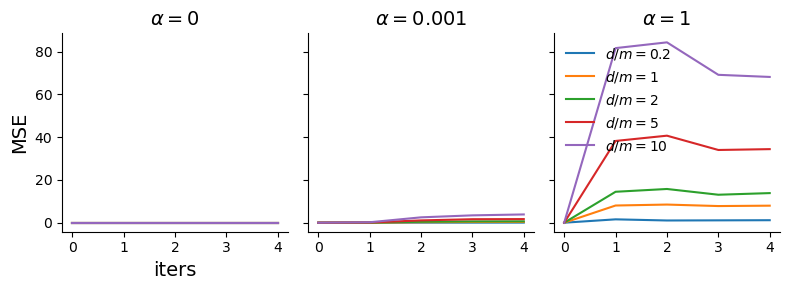

In [279]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
titles = [r'$\alpha=0$', r'$\alpha=0.001$', r'$\alpha=1$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_train, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel ('MSE')
axs[0].set_xlabel ('iters')

plt.legend(frameon=False)
#fig.suptitle('Algorithm 2 MSE w.r.t. d/m ratio')
fig.tight_layout()
#plt.savefig("DTreg_train.png")
plt.show()

**Model performance: MSE on validation set**

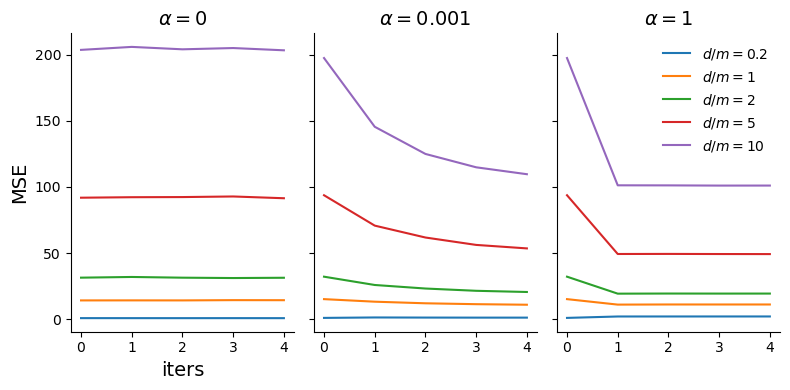

In [234]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
titles = [r'$\alpha=0$', r'$\alpha=0.001$', r'$\alpha=1$']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(8,4))

for ax, mse, title in zip(axs, mse_val, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel ('MSE')
axs[0].set_xlabel ('iters')

plt.legend(frameon=False)
#fig.suptitle('Algorithm 2 MSE w.r.t. d/m ratio')
fig.tight_layout()
#plt.savefig("DTreg_val.png")
plt.show()

**Model performance: MSE on validation by oracle models**

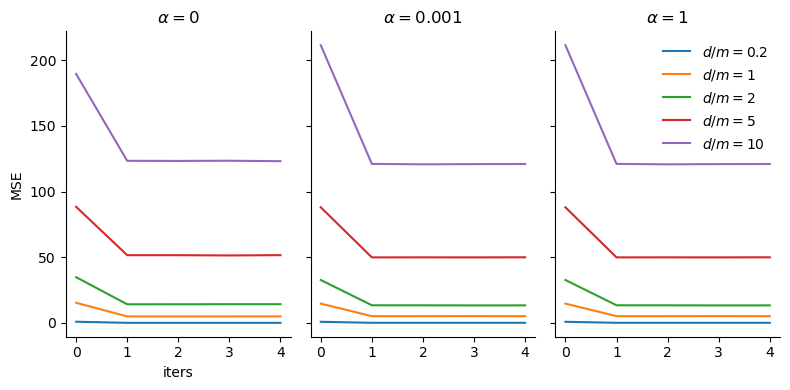

In [129]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
titles = [r'$\alpha=0$', r'$\alpha=0.001$', r'$\alpha=1$']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(8,4))

for ax, mse, mse_oracle, title in zip(axs, mse_val, mse_val_oracle, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse_oracle[i], label=labels[i])
        ax.set_title(title)

axs[0].set_ylabel ('MSE')
axs[0].set_xlabel ('iters')

plt.legend(frameon=False)
fig.tight_layout()
#plt.savefig("DTreg_val_oracle.png")
plt.show()

**Model performance: MSE on validation set scaled by oracle performance**

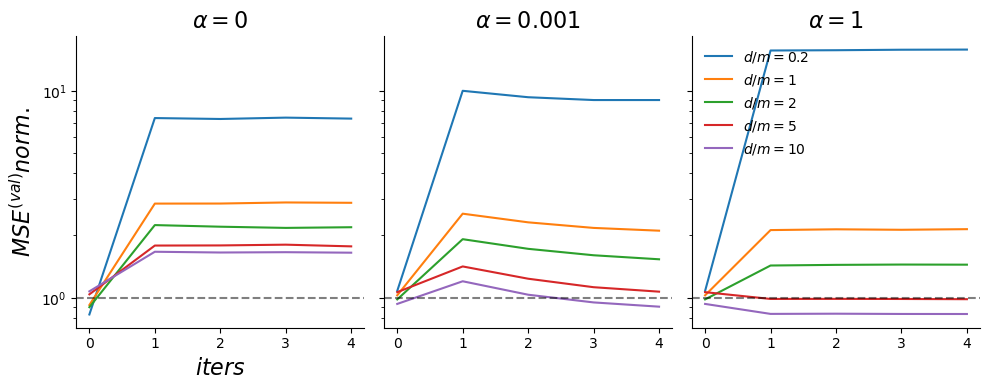

In [292]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
titles = [r'$\alpha=0$', r'$\alpha=0.001$', r'$\alpha=1$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(10,4))

for ax, mse, mse_oracle, title in zip(axs, mse_val, mse_val_oracle, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i]/mse_oracle[i], label=labels[i])
    ax.axhline(y=1,ls='--', c='k', alpha=0.5)
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(val)} norm.$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
plt.yscale("log")
#fig.suptitle('Algorithm 2 MSE w.r.t. d/m ratio')
fig.tight_layout()
plt.savefig("DTreg_clustered_MSEnorm_dm.png")
plt.show()

### Different noise levels

In [281]:
%%time

n_features = 10
reg   = [0, 0.001, 1]
noise_vals = [0, 1, 5]
iters = 5

mse_train_noise = np.zeros((len(reg),len(noise_vals), iters))
mse_val_noise = np.zeros((len(reg),len(noise_vals), iters))
mse_val_oracle_noise = np.zeros((len(reg),len(noise_vals), iters))

if save_npy:
    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for noise in noise_vals)
        
        for j in range(len(noise_vals)):
            mse_train_noise[i,j]      = out[j][0]
            mse_val_noise[i,j]        = out[j][1]
            mse_val_oracle_noise[i,j] = out[j][2]

CPU times: user 33 μs, sys: 20 μs, total: 53 μs
Wall time: 57.9 μs


In [282]:
if save_npy:
    np.save("DTreg_clustered_mse_train_noise", mse_train_noise)
    np.save("DTreg_clustered_mse_val_noise", mse_val_noise)
    np.save("DTreg_clustered_mse_val_oracle_noise", mse_val_oracle_noise)
else:
    mse_train_noise      = np.load("DTreg_clustered_mse_train_noise.npy")
    mse_val_noise        = np.load("DTreg_clustered_mse_val_noise.npy")
    mse_val_oracle_noise = np.load("DTreg_clustered_mse_val_oracle_noise.npy")

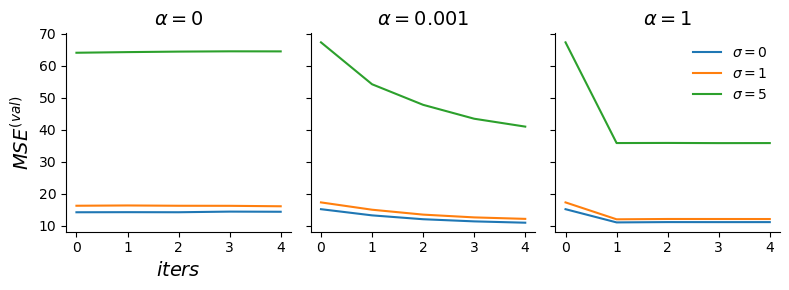

In [283]:
labels = [r'$\sigma = 0$', r'$\sigma = 1$', r'$\sigma = 5$']
titles = [r'$\alpha=0$', r'$\alpha=0.001$', r'$\alpha=1$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_val_noise, titles):
    for i in range(len(noise_vals)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(val)}$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
#fig.suptitle('Algorithm 2 MSE w.r.t. noise level, d/m=1')
fig.tight_layout()
#plt.savefig("DTreg_val_noise.png")
plt.show()

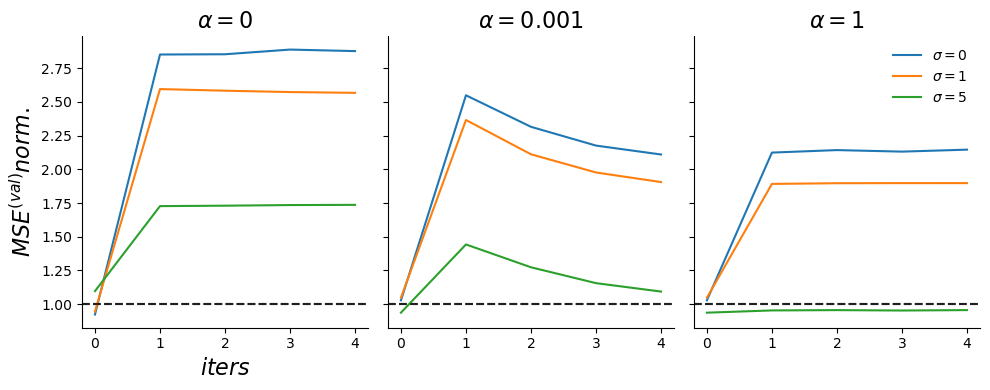

In [291]:
labels = [r'$\sigma = 0$', r'$\sigma = 1$', r'$\sigma = 5$']
titles = [r'$\alpha=0$', r'$\alpha=0.001$', r'$\alpha=1$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(10,4))

for ax, mse, mse_oracle, title in zip(axs, mse_val_noise, mse_val_oracle_noise, titles):
    for i in range(len(noise_vals)):
        ax.plot(np.arange(len(mse[i])), mse[i]/mse_oracle[i], label=labels[i])
        ax.axhline(y=1,ls='--',  c='k', alpha=0.5)
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(val)} norm.$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
#fig.suptitle('Algorithm 2 MSE w.r.t. noise level, d/m=1')
fig.tight_layout()
plt.savefig("DTreg_clustered_MSEnorm_noise.png")
plt.show()